# Feature Analysis & Feature Engineering

In this notebook, I explore a few simple feature ideas for the Titanic dataset.

The goal is to understand whether these features make sense and how they relate to survival.

Final feature engineering code is implemented in `src/features.py`.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv("../data/titanic-dataset.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.shape


(891, 12)

In [9]:
df.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64

### Feature 1: Title

The passenger's title (Mr., Mrs., Ms., etc.) has been extracted from the `Name` column.
This can be useful as titles may be related to gender, age group, and social status.


In [20]:
title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Ms': 'Miss', 'Lady': 'Rare', 'Sir': 'Rare',
        'Mme': 'Mrs', 'Don': 'Rare', 'Capt': 'Rare', 'Countess': 'Rare',
        'Jonkheer': 'Rare', 'Dona': 'Rare'
    }

In [21]:
def extract_title(name):
    for title in title_mapping:
        if title + "." in name:
            return title_mapping[title]
    return "Rare"

In [22]:
df["Title"] = df["Name"].apply(extract_title)

### Feature 2. FamilySize and IsAlone

FamilySize was constructed by combining the number of siblings/spouses and parents/children aboard.

Based on this feature, a binary IsAlone indicator was derived to distinguish passengers traveling alone from those traveling with family members.

In [23]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

## Feature 3: TicketGroupSize


A new feature, TicketGroupSize, was created to capture the number of passengers sharing the same ticket. This feature may reflect group or family travel patterns, which could be associated with survival outcomes.

In [24]:
df["TicketGroupSize"] = df.groupby("Ticket")["Ticket"].transform("count")

## Handling missing Embarked

Missing values in the Embarked feature were filled using the most frequent category (mode). This approach is appropriate for categorical variables and helps maintain the original distribution.

In [25]:
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

## Handling Missing Age Values


I filled missing Age values using the median age within each Title group.
This approach keeps the imputation simple while preserving age differences
between passenger groups.

In [26]:
df["Age"] = df.groupby("Title")["Age"].transform(
    lambda x: x.fillna(x.median())
)

In [27]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,TicketGroupSize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,1


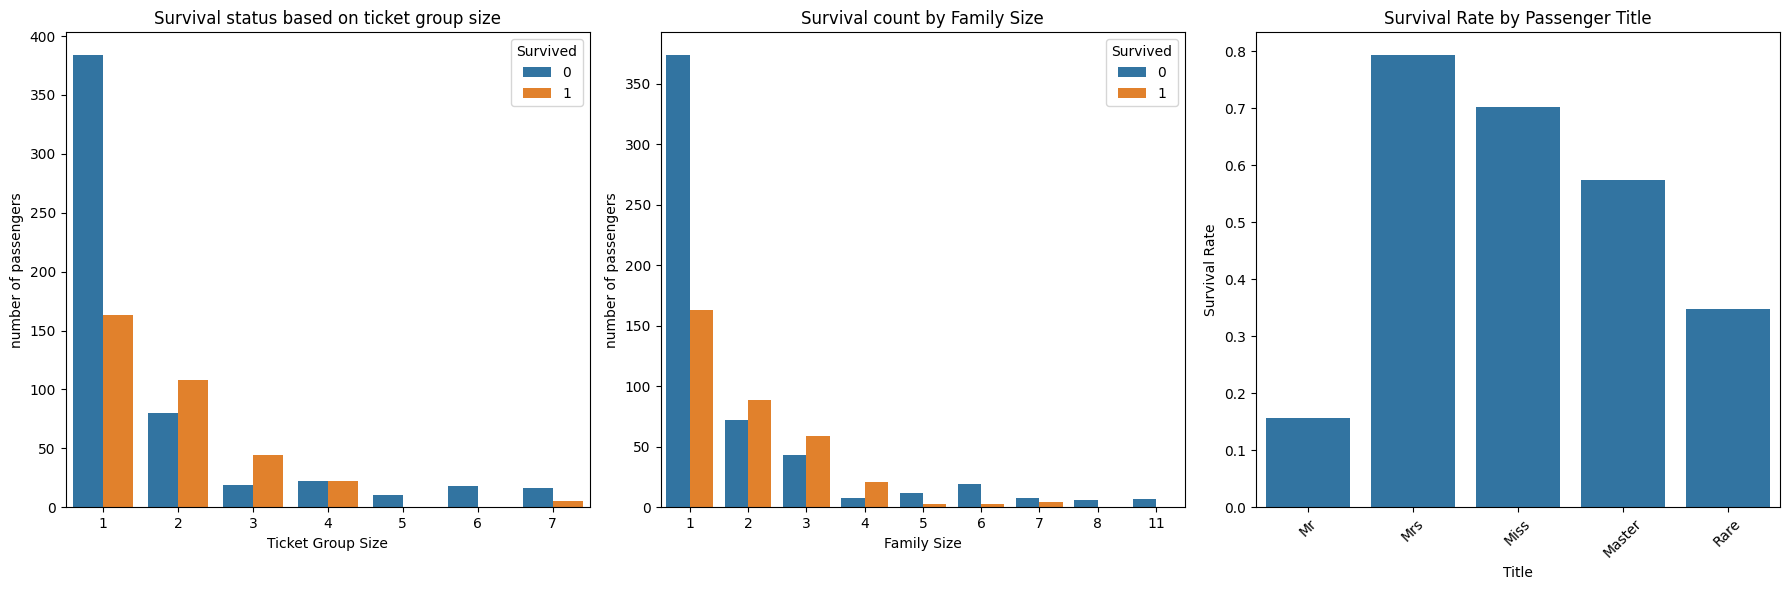

In [28]:
fig, axes = plt.subplots(1,3, figsize=(18,6))

sns.countplot(data=df, x="TicketGroupSize", hue="Survived", ax=axes[0])
axes[0].set_xlabel("Ticket Group Size")
axes[0].set_ylabel("number of passengers")
axes[0].set_title("Survival status based on ticket group size")


sns.countplot(data=df, x="FamilySize", hue="Survived", ax=axes[1])
axes[1].set_xlabel("Family Size")
axes[1].set_ylabel("number of passengers")
axes[1].set_title("Survival count by Family Size")

sns.barplot(data=df, x="Title", y="Survived", ax=axes[2], errorbar=None)
axes[2].set_xlabel("Title")
axes[2].set_ylabel("Survival Rate")
axes[2].set_title("Survival Rate by Passenger Title")
axes[2].tick_params(axis="x", labelrotation=45)

plt.tight_layout()
plt.show()

These visualizations examine the relationship between new features and survival.

- TicketGroupSize: Examines how survival varies with the number of passengers sharing the same ticket, highlighting group travel effects.
- FamilySize: Shows survival counts by family size, helping identify the impact of traveling alone versus with family.
- Title: Displays survival rates across passenger titles, capturing socio-demographic differences.

Together, these plots provide insights into how social structure and passenger characteristics influence survival probability.

In [29]:
drop_cols = ["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Cabin"]
df = df.drop(drop_cols, axis=1)

Several features were removed after feature engineering to reduce redundancy and noise. These included identifiers, high-cardinality features, and variables whose information was captured by engineered features.

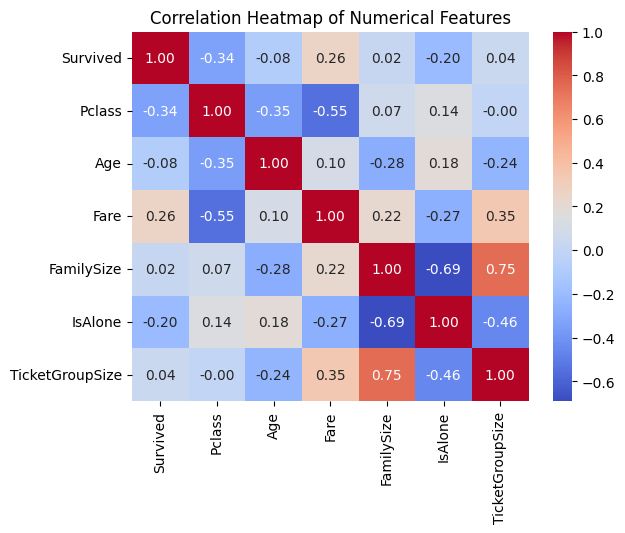

In [30]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

This heatmap shows the relationships between numerical features and the target variable (Survived).

Key takeaways:

- Pclass has a negative correlation with survival, meaning passengers in higher classes were more likely to survive.
- Fare is positively correlated with survival, indicating that passengers who paid higher fares had better survival rates.
- IsAlone shows a negative correlation with survival, suggesting that passengers traveling alone were less likely to survive.
- FamilySize*and TicketGroupSize are strongly correlated, as both represent group travel behavior.
- Age has a weak correlation with survival, showing a limited linear relationship.

This step provides a basic understanding of feature relationships and supports informed feature selection before modeling.